In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

import calendar

from src.paths import SQL_DB_DIR
from src.paths import TAXI_ZONES_DIR

In [68]:
# Create connection to sqlite.
conn = sqlite3.connect(SQL_DB_DIR/'nyc_taxi_data.db')

# Read only the column names into pandas for DataFrame structure review.
df_columns = pd.read_sql_query('SELECT * FROM yellow_taxi_data LIMIT 1', conn)
df_columns.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
airport_fee              float64
dtype: object

In [69]:
query = """
WITH pickup_counts AS (
    SELECT tpep_pickup_datetime AS date_time, COUNT(*) AS pickup_count
    FROM yellow_taxi_data
    GROUP BY date_time
),
dropoff_counts AS (
    SELECT tpep_dropoff_datetime AS date_time, COUNT(*) AS dropoff_count
    FROM yellow_taxi_data
    GROUP BY date_time
)

SELECT p.date_time AS date_time, p.pickup_count, d.dropoff_count
FROM pickup_counts p
LEFT JOIN dropoff_counts d ON p.date_time = d.date_time
ORDER BY p.date_time
"""

df = pd.read_sql_query(query, con=conn)

In [70]:
df.sample(10)

,date_time,pickup_count,dropoff_count
6350087,2023-04-29 10:14:27.000000,2,2.0
18320725,2023-12-10 10:05:21.000000,1,3.0
2569629,2023-02-18 20:31:13.000000,2,2.0
1386230,2023-01-27 18:02:14.000000,3,1.0
6149551,2023-04-25 19:33:48.000000,3,3.0
16735176,2023-11-11 11:54:36.000000,3,1.0
14110336,2023-09-25 14:04:01.000000,3,1.0
9442581,2023-06-24 00:16:03.000000,2,NaN
11194201,2023-07-27 23:11:24.000000,1,2.0
1287914,2023-01-25 21:46:53.000000,1,1.0


In [71]:
# Convert 'date_time' datatype from object to datetime
df['date_time'] = pd.to_datetime(df['date_time'])

# Extract and create a floored 'hour' column from 'date_time'.
df['hour'] = df['date_time'].dt.floor('h').dt.hour

# Fill NaN values with 0 for both pickup_count and dropoff_count
df['pickup_count'] = df['pickup_count'].fillna(0)
df['dropoff_count'] = df['dropoff_count'].fillna(0)

# Convert counts to integers (after filling NaNs, which allows for integer conversion)
df['pickup_count'] = df['pickup_count'].astype(int)
df['dropoff_count'] = df['dropoff_count'].astype(int)
df

,date_time,pickup_count,dropoff_count,hour
0,2023-01-01 00:00:00,1,0,0
1,2023-01-01 00:00:05,1,0,0
2,2023-01-01 00:00:06,1,0,0
3,2023-01-01 00:00:08,1,0,0
4,2023-01-01 00:00:09,1,0,0
...,...,...,...,...
19448008,2023-12-31 23:59:51,2,2,23
19448009,2023-12-31 23:59:52,1,2,23
19448010,2023-12-31 23:59:57,1,0,23
19448011,2023-12-31 23:59:58,1,0,23


In [72]:
# Aggregate and ensure it's done on this 'hour' which is the floored datetime
df_hours_grouped_sum = df[['hour', 'pickup_count', 'dropoff_count']].groupby('hour').agg({
    'pickup_count': 'sum',
    'dropoff_count': 'sum'
}).reset_index()
df_hours_grouped_sum

,hour,pickup_count,dropoff_count
0,0,1088604,760524
1,1,731321,443225
2,2,483366,249373
3,3,319640,125142
4,4,217491,54056
5,5,226410,34794
6,6,532181,163390
7,7,1044239,534631
8,8,1446061,937470
9,9,1632600,1153640


In [73]:
# Create a Plotly figure
fig = go.Figure()

# Add a line for pickup counts
fig.add_trace(go.Scatter(x=df_hours_grouped_sum['hour'], 
                         y=df_hours_grouped_sum['pickup_count'],
                         mode='lines+markers', 
                         name='Pickup'))

# Add a line for dropoff counts
fig.add_trace(go.Scatter(x=df_hours_grouped_sum['hour'], 
                         y=df_hours_grouped_sum['dropoff_count'],
                         mode='lines+markers', 
                         name='Dropoff'))

# Update figure layout
fig.update_layout(title='Taxi Pickup and Dropoff Counts by Hour',
                  xaxis_title='Hour of the Day',
                  yaxis_title='Count',
                  legend_title='Activity Type',
                  template='plotly_dark')

# Show the figure
fig.show()


In [74]:
# Compute the average counts
df_hours_grouped_avg = df_hours_grouped_sum.copy()
df_hours_grouped_avg['pickup_count'] = df_hours_grouped_sum['pickup_count'] / df_hours_grouped_sum['pickup_count'].count()
df_hours_grouped_avg['dropoff_count'] = df_hours_grouped_sum['dropoff_count'] / df_hours_grouped_sum['dropoff_count'].count()

df_hours_grouped_avg

,hour,pickup_count,dropoff_count
0,0,45358.500000,31688.500000
1,1,30471.708333,18467.708333
2,2,20140.250000,10390.541667
3,3,13318.333333,5214.250000
4,4,9062.125000,2252.333333
5,5,9433.750000,1449.750000
6,6,22174.208333,6807.916667
7,7,43509.958333,22276.291667
8,8,60252.541667,39061.250000
9,9,68025.000000,48068.333333


In [75]:
# Create a Plotly figure for averages
fig_avg = go.Figure()

# Add a line for average pickup counts
fig_avg.add_trace(go.Scatter(x=df_hours_grouped_avg['hour'], 
                             y=df_hours_grouped_avg['pickup_count'],
                             mode='lines+markers', 
                             name='Average Pickup'))

# Add a line for average dropoff counts
fig_avg.add_trace(go.Scatter(x=df_hours_grouped_avg['hour'], 
                             y=df_hours_grouped_avg['dropoff_count'],
                             mode='lines+markers', 
                             name='Average Dropoff'))

# Update figure layout to reflect averages
fig_avg.update_layout(title='Average Taxi Pickup and Dropoff by Hour of the Day',
                      xaxis_title='Hour of the Day',
                      yaxis_title='Average Count',
                      legend_title='Activity Type',
                      template='plotly_dark')

# Show the figure
fig_avg.show()


In [76]:
# Extract 'day_of_week' column from df_peak_hours['date_time] and convert to category.
df['day_of_week'] = pd.Categorical(df['date_time'].dt.dayofweek + 1,
                                               categories=range(1, 8), ordered=True)
df['month'] = df['date_time'].dt.month

df['day_name'] = df['date_time'].dt.day_of_week.apply(lambda x: calendar.day_name[x])

df['month_name'] = df['date_time'].dt.month.apply(lambda x: calendar.month_name[x])
df

,date_time,pickup_count,dropoff_count,hour,day_of_week,month,day_name,month_name
0,2023-01-01 00:00:00,1,0,0,7,1,Sunday,January
1,2023-01-01 00:00:05,1,0,0,7,1,Sunday,January
2,2023-01-01 00:00:06,1,0,0,7,1,Sunday,January
3,2023-01-01 00:00:08,1,0,0,7,1,Sunday,January
4,2023-01-01 00:00:09,1,0,0,7,1,Sunday,January
...,...,...,...,...,...,...,...,...
19448008,2023-12-31 23:59:51,2,2,23,7,12,Sunday,December
19448009,2023-12-31 23:59:52,1,2,23,7,12,Sunday,December
19448010,2023-12-31 23:59:57,1,0,23,7,12,Sunday,December
19448011,2023-12-31 23:59:58,1,0,23,7,12,Sunday,December


In [77]:
# Sum
df_dayofweek_sum = df.groupby('day_of_week', observed=False).agg({
    'pickup_count': 'sum',
    'dropoff_count': 'sum'
}).reset_index()

df_dayofweek_sum

,day_of_week,pickup_count,dropoff_count
0,1,4775129,3495849
1,2,5537758,4336490
2,3,5864960,4666246
3,4,6002310,4798723
4,5,5702311,4418508
5,6,5582487,4245372
6,7,4845167,3444735


In [78]:
# Mean
df_dayofweek_mean = df_dayofweek_sum.copy()
df_dayofweek_mean['pickup_count'] = df_dayofweek_mean['pickup_count'] / df_dayofweek_mean['pickup_count'].count()
df_dayofweek_mean['dropoff_count'] = df_dayofweek_mean['dropoff_count'] / df_dayofweek_mean['dropoff_count'].count()

df_dayofweek_mean

,day_of_week,pickup_count,dropoff_count
0,1,682161.285714,499407.000000
1,2,791108.285714,619498.571429
2,3,837851.428571,666606.571429
3,4,857472.857143,685531.857143
4,5,814615.857143,631215.428571
5,6,797498.142857,606481.714286
6,7,692166.714286,492105.000000


In [79]:
# Visualize sum by day of the week
fig_day_sum = go.Figure()

fig_day_sum.add_trace(go.Scatter(x=df_dayofweek_sum['day_of_week'], 
                                 y=df_dayofweek_sum['pickup_count'],
                                 mode='lines+markers', 
                                 name='Pickup Sum'))
fig_day_sum.add_trace(go.Scatter(x=df_dayofweek_sum['day_of_week'], 
                                 y=df_dayofweek_sum['dropoff_count'],
                                 mode='lines+markers', 
                                 name='Dropoff Sum'))

fig_day_sum.update_layout(title='Total Taxi Pickup and Dropoff Counts by Day of the Week',
                          xaxis_title='Day of the Week',
                          yaxis_title='Total Count',
                          legend_title='Activity Type',
                          template='plotly_dark')
fig_day_sum.show()

In [80]:
# Visualize mean by day of the week
fig_day_mean = go.Figure()

fig_day_mean.add_trace(go.Scatter(x=df_dayofweek_mean['day_of_week'], 
                                  y=df_dayofweek_mean['pickup_count'],
                                  mode='lines+markers', 
                                  name='Pickup Average'))
fig_day_mean.add_trace(go.Scatter(x=df_dayofweek_mean['day_of_week'], 
                                  y=df_dayofweek_mean['dropoff_count'],
                                  mode='lines+markers', 
                                  name='Dropoff Average'))

fig_day_mean.update_layout(title='Average Taxi Pickup and Dropoff Counts by Day of the Week',
                           xaxis_title='Day of the Week',
                           yaxis_title='Average Count',
                           legend_title='Activity Type',
                           template='plotly_dark')
fig_day_mean.show()


In [81]:
# df['month'] = df['date_time'].dt.month
df_monthly_trips = df.groupby('month', observed=False).agg({
    'pickup_count': 'sum',
    'dropoff_count': 'sum'
}).reset_index()
df_monthly_trips

,month,pickup_count,dropoff_count
0,1,3066726,2297389
1,2,2914003,2226022
2,3,3403660,2654133
3,4,3288248,2558593
4,5,3513664,2770867
5,6,3307259,2564942
6,7,2907093,2108454
7,8,2824201,2022075
8,9,2846741,2176849
9,10,3522269,2774417


In [82]:
df_monthly_trips_avg = df_monthly_trips.copy()
df_monthly_trips_avg['pickup_count'] = df_monthly_trips_avg['pickup_count'] / df_monthly_trips_avg['pickup_count'].count()
df_monthly_trips_avg['dropoff_count'] = df_monthly_trips_avg['dropoff_count'] / df_monthly_trips_avg['dropoff_count'].count()
df_monthly_trips_avg

,month,pickup_count,dropoff_count
0,1,255560.500000,191449.083333
1,2,242833.583333,185501.833333
2,3,283638.333333,221177.750000
3,4,274020.666667,213216.083333
4,5,292805.333333,230905.583333
5,6,275604.916667,213745.166667
6,7,242257.750000,175704.500000
7,8,235350.083333,168506.250000
8,9,237228.416667,181404.083333
9,10,293522.416667,231201.416667


In [83]:
# Create a Plotly figure
fig = go.Figure()

# Add a line for pickup counts
fig.add_trace(go.Scatter(x=df_monthly_trips['month'], 
                         y=df_monthly_trips['pickup_count'],
                         mode='lines+markers', 
                         name='Pickup'))

# Add a line for dropoff counts
fig.add_trace(go.Scatter(x=df_monthly_trips['month'], 
                         y=df_monthly_trips['dropoff_count'],
                         mode='lines+markers', 
                         name='Dropoff'))

# Update figure layout
fig.update_layout(title='Monthly Taxi Trips Over Time',
                  xaxis_title='Month',
                  yaxis_title='Number of Trips',
                  legend_title='Activity Type',
                  template='plotly_dark')

# Show the figure
fig.show()


#### Examining short and long distance trips differences.

In [84]:
# Query to select trip distance column.
query = """
SELECT trip_distance
FROM yellow_taxi_data;
"""
df_trip_dist = pd.read_sql_query(query, con=conn)

# Statistical summary of the trip-distance column.
df_trip_dist.describe()

,trip_distance
count,3.831012e+07
mean,4.088941e+00
std,2.412512e+02
min,0.000000e+00
25%,1.040000e+00
50%,1.790000e+00
75%,3.400000e+00
max,3.457294e+05


#### Analyzing Outliers
Given that this dataset pertains to NYC yellow taxis, the presence of a maximum trip distance of over 345,729 miles is definitely an error, as it is highly improbable for any taxi trip within or around New York City to cover such distances. This strongly suggests data entry errors or anomalies within the dataset

In [85]:
# Display trips with exceptionally high distances
outliers = df_trip_dist[df_trip_dist['trip_distance'] > 100]  # Arbitrary high cutoff to identify outliers
outliers

,trip_distance
45907,105.55
62607,62359.52
83242,114.27
141636,105.24
185920,9680.61
...,...
38260867,35802.34
38264567,35913.11
38292600,39307.76
38294596,24131.45


Removing Outliers

In [86]:
# Remove outliers: trips longer than 100 miles might be considered unrealistic
df_trip_dist_clean = df_trip_dist[df_trip_dist['trip_distance'] <= 100]  # Capping at 100 miles, adjust as reasonable

# Recalculate statistics with cleaned data
stats_clean = df_trip_dist_clean.describe()
stats_clean

,trip_distance
count,3.830882e+07
mean,3.452371e+00
std,4.545522e+00
min,0.000000e+00
25%,1.040000e+00
50%,1.790000e+00
75%,3.400000e+00
max,9.992000e+01


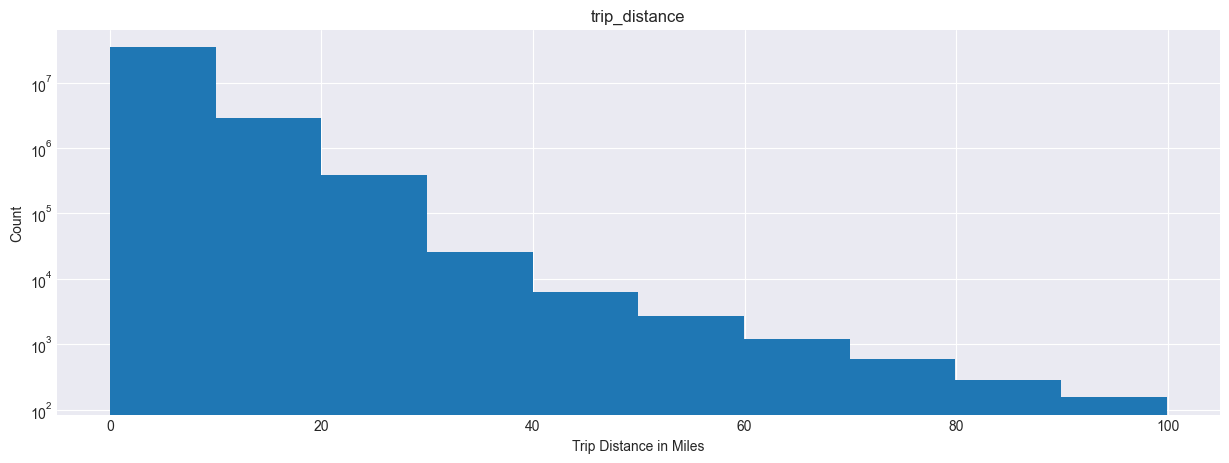

In [87]:
# Create the histogram and get the single Axes object by indexing
ax = df_trip_dist_clean.hist(figsize=(15, 5))[0][0]  # Index to get the first (and only) Axes if only one column is present

# Set the properties on the Axes object
ax.set_yscale('log')
ax.set_xlabel('Trip Distance in Miles')
ax.set_ylabel('Count')

plt.show()

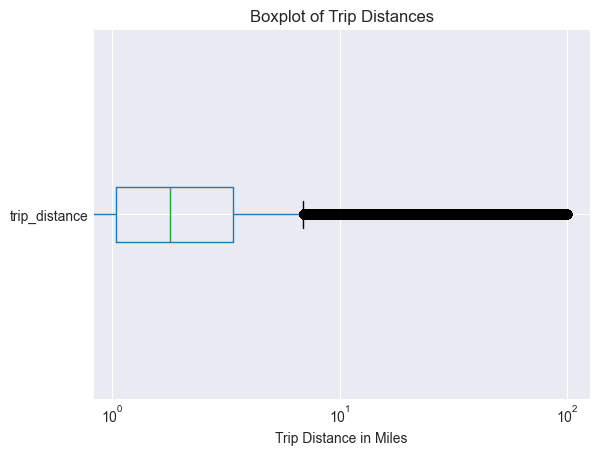

In [88]:
df_trip_dist_clean.boxplot(column='trip_distance', vert=False)  # `vert=False` makes the boxplot horizontal
plt.xscale('log')  # Setting a logarithmic scale due to wide data range
plt.xlabel('Trip Distance in Miles')
plt.title('Boxplot of Trip Distances')
plt.show()

From the boxplot, it seems that the vast majority of the trips are short distances with some outliers stretching into very long distances. Considering we have a lot of outliers, let's say we define short trips as being ≤ 75th percentile / 0.75 quantile (3.4 miles in the data)

In [89]:
Q1 = df_trip_dist_clean['trip_distance'].quantile(0.25) # First quartile/ 25th percentile
Q3 = df_trip_dist_clean['trip_distance'].quantile(0.75) # Third quartile / 75th percentile
IQR = Q3 - Q1 # Interquartile range i.e distance bewteen Q3 and Q1.
IQR

2.36

In [90]:
df_trip_dist_clean.shape

(38308818, 1)

In [91]:
# Find indices of trips longer than the new upper quartile
indices_clean = np.where(df_trip_dist_clean['trip_distance'] > Q3)[0]

# Assuming 'df' aligns with the cleaned 'df_trip_dist_clean'
long_trips_clean = df_trip_dist_clean.iloc[indices_clean]

# Statistics of long trips
long_trip_stats = long_trips_clean.describe()
long_trip_stats

,trip_distance
count,9.565471e+06
mean,9.343614e+00
std,5.879343e+00
min,3.410000e+00
25%,4.590000e+00
50%,7.440000e+00
75%,1.222000e+01
max,9.992000e+01


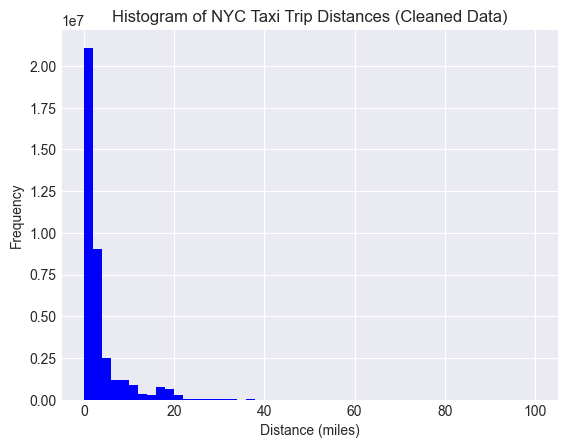

In [92]:
# Histogram of trip distances after cleaning
plt.hist(df_trip_dist_clean['trip_distance'], bins=50, color='blue', range=[0, 100])
plt.title('Histogram of NYC Taxi Trip Distances (Cleaned Data)')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.show()

In [93]:
treshhold = df_trip_dist_clean['trip_distance'].quantile(0.75)

# Use vectorized operations to calculate short and long trip counts
short_trips_count = (df_trip_dist_clean['trip_distance'] <= treshhold).sum()
long_trips_count = (df_trip_dist_clean['trip_distance'] > treshhold).sum()

print(f"Short Trips: {short_trips_count} records in total.\nLong Trips: {long_trips_count} records in total.")

Short Trips: 28743347 records in total.
Long Trips: 9565471 records in total.


SQL query to include a cap on the trip distance at 100 miles and classify trips into "short" (≤ 3.4 miles) and "long" (> 3.4 miles) within this cap, we can adjust the CASE statement to exclude any distances beyond this limit.

In [94]:
query_pickup = """
SELECT 
  strftime('%H', tpep_pickup_datetime) AS hour,
  SUM(CASE WHEN trip_distance <= 3.4 THEN 1 ELSE 0 END) AS short_trips,
  SUM(CASE WHEN trip_distance > 3.4 THEN 1 ELSE 0 END) AS long_trips
FROM 
  yellow_taxi_data
WHERE
  trip_distance <= 100
GROUP BY 
  hour
ORDER BY 
  hour;
"""

query_dropoff = """
SELECT 
  strftime('%H', tpep_dropoff_datetime) AS hour,
  SUM(CASE WHEN trip_distance <= 3.4 THEN 1 ELSE 0 END) AS short_trips,
  SUM(CASE WHEN trip_distance > 3.4 THEN 1 ELSE 0 END) AS long_trips
FROM 
  yellow_taxi_data
WHERE
  trip_distance <= 100
GROUP BY 
  hour
ORDER BY 
  hour;
"""
df_pickup = pd.read_sql_query(query_pickup, conn)
df_dropoff = pd.read_sql_query(query_dropoff, conn)

# Optionally, rename columns for clarity
df_pickup.rename(columns={
    'hour': 'Hour',
    'short_trips': 'Short Trips',
    'long_trips': 'Long Trips'
}, inplace=True)

df_dropoff.rename(columns={
    'hour': 'Hour',
    'short_trips': 'Short Trips',
    'long_trips': 'Long Trips'
}, inplace=True)

def complete_hour_data(df):
    # Ensure all hours are represented
    all_hours = pd.DataFrame({'Hour': [f"{h:02}" for h in range(24)]})
    return pd.merge(all_hours, df, on='Hour', how='left').fillna(0).astype(
        {'Short Trips': int, 'Long Trips': int}).sort_values(by='Hour')

df_pickup_complete = complete_hour_data(df_pickup)
df_dropoff_complete = complete_hour_data(df_dropoff)

## Alternatively

In [95]:
# Query to fetch data for both short and long trips in a single query
query = """
SELECT 
  strftime('%H', tpep_pickup_datetime) AS pickup_hour,
  strftime('%H', tpep_dropoff_datetime) AS dropoff_hour,
  SUM(CASE WHEN trip_distance <= 3.4 THEN 1 ELSE 0 END) AS short_trips,
  SUM(CASE WHEN trip_distance > 3.4 THEN 1 ELSE 0 END) AS long_trips
FROM 
  yellow_taxi_data
WHERE
  trip_distance <= 100 -- Ensuring that all considered trips are within the realistic range
GROUP BY 
  pickup_hour, dropoff_hour
ORDER BY 
  pickup_hour, dropoff_hour;
"""
df_trips = pd.read_sql_query(query, conn)
df_trips

,pickup_hour,dropoff_hour,short_trips,long_trips
0,00,00,629433,243629
1,00,01,91088,123657
2,00,02,20,213
3,00,03,2,19
4,00,04,0,3
...,...,...,...,...
523,23,19,2,3
524,23,20,4,11
525,23,21,7,29
526,23,22,210,131


In [96]:
# Rename the columns to make them more readable:
df_trips.rename(columns={
    'pickup_hour': 'Pickup Hour',
    'dropoff_hour': 'Dropoff Hour',
    'short_trips': 'Short Trips',
    'long_trips': 'Long Trips'
}, inplace=True)

In [97]:
# Aggregation for activity hours
def aggregate_trips_by_hour(df, hour_column):
    try:
        # Check if the hour_column exists in DataFrame
        if hour_column not in df.columns:
            raise ValueError(f"{hour_column} not found in DataFrame")
        
        # Aggregate the data
        aggregated = df.groupby(hour_column).agg(
            {'Short Trips': 'sum', 'Long Trips': 'sum'}
        ).reset_index()
        
        # Ensure all hours are represented
        all_hours = pd.DataFrame({hour_column: [f"{h:02}" for h in range(24)]})
        aggregated = pd.merge(all_hours, aggregated, on=hour_column, how='left').fillna(0)
        
        # Convert trips count back to integer if they were filled with NaNs
        aggregated['Short Trips'] = aggregated['Short Trips'].astype(int)
        aggregated['Long Trips'] = aggregated['Long Trips'].astype(int)

        return aggregated.sort_values(by=hour_column)
    except Exception as e:
        print("An error occurred:", e)
        return None

pickup_aggregated = aggregate_trips_by_hour(df_trips, 'Pickup Hour')
dropoff_aggregated = aggregate_trips_by_hour(df_trips, 'Dropoff Hour')


In [98]:
pickup_aggregated

,Pickup Hour,Short Trips,Long Trips
0,00,720819,367760
1,01,503561,227744
2,02,337315,146034
3,03,214132,105495
4,04,123552,93916
5,05,125534,100842
6,06,348846,183262
7,07,778658,265495
8,08,1120208,325783
9,09,1266079,366464


In [99]:
dropoff_aggregated

,Dropoff Hour,Short Trips,Long Trips
0,00,774652,463649
1,01,532522,280642
2,02,361195,173881
3,03,229084,113902
4,04,136060,97910
5,05,114143,85841
6,06,304555,135134
7,07,687164,215980
8,08,1054663,289318
9,09,1238218,352946


In [100]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

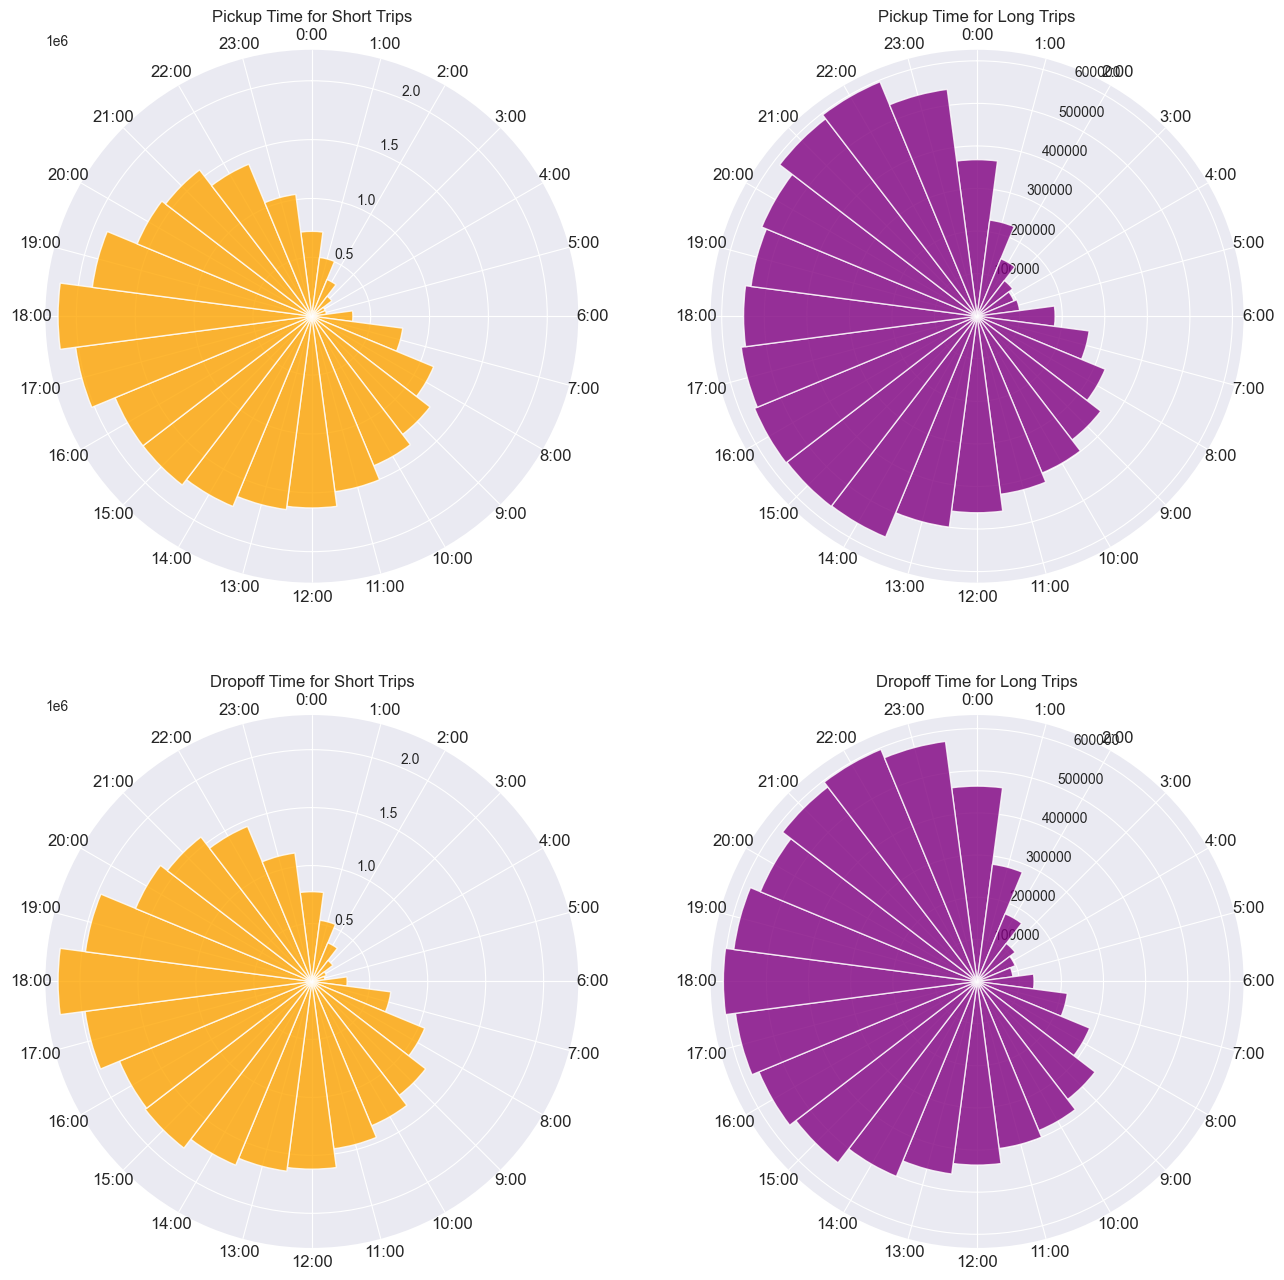

In [101]:
# Set style for nice aesthetics
plt.style.use('seaborn-v0_8-darkgrid')

def plt_clock(ax, data, title, color):
    # Generate 24-hour intervals
    theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)
    width = (2 * np.pi) / 24  # width of each bin

    # Make sure data is a Pandas Series to use the .max() method
    if isinstance(data, list):
        data = pd.Series(data)
    
    # Normalize data for better visibility if the scale is too large
    data_normalized = data / data.max() * 100

    # Bar plot on polar axis
    bars = ax.bar(theta, data, width=width, bottom=2, color=color, alpha=0.8, edgecolor='white')
    ax.set_theta_zero_location("N")  # North at top
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_xticks(theta)
    ticks = [f"{x}:00" for x in range(24)]
    ax.set_xticklabels(ticks, fontsize=12, rotation=45)
    ax.set_title(title, pad=20)
    

def plot_trip_data(pickup_data, dropoff_data):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14), subplot_kw={'polar': True})
    titles = ['Pickup Time for Short Trips', 'Pickup Time for Long Trips', 
              'Dropoff Time for Short Trips', 'Dropoff Time for Long Trips']
    colors = ['#FFA500', '#800080', '#FFA500', '#800080'] # Orange and Purple colors

    for i, ax in enumerate(axs.flat):
        # Selecting the right data series based on the subplot index
        data = pickup_data if i < 2 else dropoff_data
        trips = 'Short Trips' if i % 2 == 0 else 'Long Trips'
        plt_clock(ax, data[trips].tolist(), titles[i], colors[i])

    plt.tight_layout(pad=5)
    plt.show()

# Call the function with prepared data
plot_trip_data(pickup_aggregated, dropoff_aggregated)

## OR

In [102]:
# Query for fetching only the necessary columns for trip distance analysis
query = """
SELECT tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance
FROM yellow_taxi_data
WHERE trip_distance <= 100
"""

# Read the SQL query into a Pandas DataFrame, parsing datetime columns directly
df = pd.read_sql_query(query, conn, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

# Floor the pickup and dropoff datetime to the nearest hour and extract the hour
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.floor('h').dt.hour
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.floor('h').dt.hour

# Define the short and long trips within the DataFrame using numpy for vectorized condition checking
df['trip_category'] = np.where(df['trip_distance'] <= 3.4, 'short_trips', 'long_trips')

# Group by pickup hour and trip category, count the occurrences, then unstack and fill NaNs with 0
df_pickup_grouped = df.groupby(['pickup_hour', 'trip_category']).size().unstack(fill_value=0).reset_index()
df_dropoff_grouped = df.groupby(['dropoff_hour', 'trip_category']).size().unstack(fill_value=0).reset_index()


In [103]:
df_pickup_grouped

trip_category,pickup_hour,long_trips,short_trips
0,0,367760,720819
1,1,227744,503561
2,2,146034,337315
3,3,105495,214132
4,4,93916,123552
5,5,100842,125534
6,6,183262,348846
7,7,265495,778658
8,8,325783,1120208
9,9,366464,1266079


In [104]:
df_dropoff_grouped

trip_category,dropoff_hour,long_trips,short_trips
0,0,463649,774652
1,1,280642,532522
2,2,173881,361195
3,3,113902,229084
4,4,97910,136060
5,5,85841,114143
6,6,135134,304555
7,7,215980,687164
8,8,289318,1054663
9,9,352946,1238218


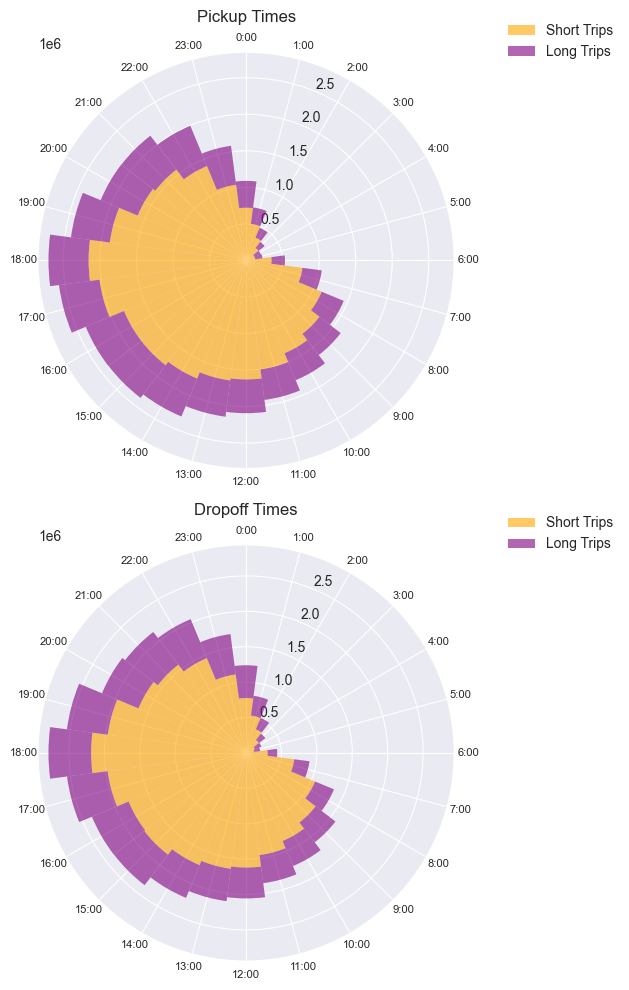

In [105]:
def plt_clock(ax, hours, data_short, data_long, title):
    theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)
    width = (2 * np.pi) / 24

    bars_short = ax.bar(theta, data_short, width=width, bottom=0, color='#FFA500', alpha=0.6, label='Short Trips')
    bars_long = ax.bar(theta, data_long, width=width, bottom=data_short, color='#800080', alpha=0.6, label='Long Trips')
    
    ax.set_theta_zero_location("N")  # set 0 at the top
    ax.set_theta_direction(-1)  # set the direction clockwise
    ax.set_xticks(theta)
    ax.set_xticklabels([f"{h}:00" for h in hours], fontsize=8, rotation=45)
    ax.set_title(title, va='bottom')
    ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))

# Data for plotting
hours = df_pickup_grouped['pickup_hour']
data_short_pickup = df_pickup_grouped['short_trips']
data_long_pickup = df_pickup_grouped['long_trips']

hours = df_dropoff_grouped['dropoff_hour']
data_short_dropoff = df_dropoff_grouped['short_trips']
data_long_dropoff = df_dropoff_grouped['long_trips']

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 10), subplot_kw={'projection': 'polar'})
plt_clock(ax[0], hours, data_short_pickup, data_long_pickup, 'Pickup Times')
plt_clock(ax[1], hours, data_short_dropoff, data_long_dropoff, 'Dropoff Times')

plt.tight_layout()
plt.show()

In [106]:
conn.close()